In [1]:
dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/Behavior Hypotheses/behavior-hypotheses/src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
sceneId = 210
sceneId2 = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
pedDf2 = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId2}-pedestrians.csv"))
# otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

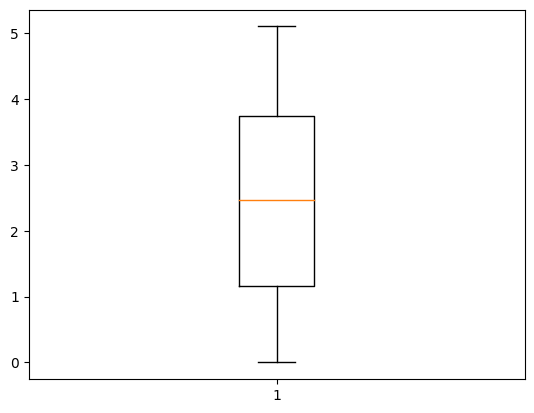

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6cbdf92920>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6cbdf92e60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6cbdf92680>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6cbdf933a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6cbdf93640>],
 'means': []}

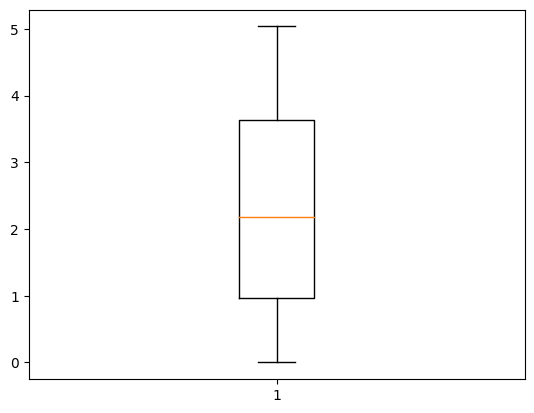

In [6]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)

transformer.deriveSpeed(pedDf2)
transformer.deriveDisplacements(pedDf2)
transformer.deriveAcceleration(pedDf2)

plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf2['displacementY'])

In [37]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

In [38]:
# max and min values of speed
print(cleanPedDf['speed'].max())
print(cleanPedDf['speed'].min())



1.1156748327805872
0.18725550726214213


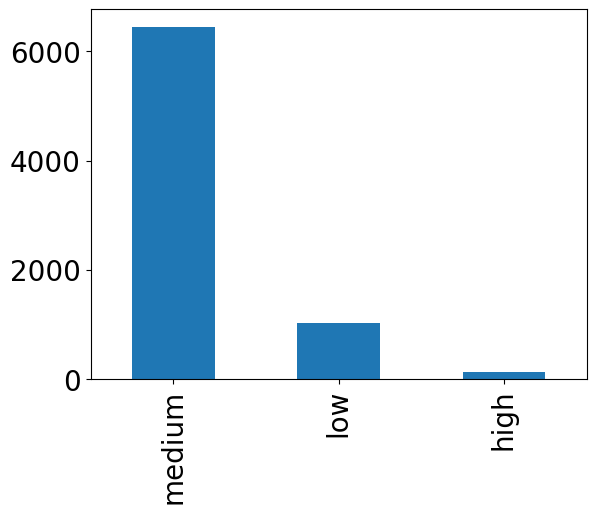

In [39]:
# categorize speed into 3 bins
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=3, labels=['low', 'medium', 'high'])
cleanPedDf['speedCategory'].value_counts()
cleanPedDf['speedCategory'].value_counts().plot(kind='bar')
plt.show()

In [40]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,low
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,low
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,low
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,low
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,medium
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,medium
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,medium
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,medium


In [41]:
# min and max of low, medium and high speed
print(cleanPedDf[cleanPedDf['speedCategory'] == 'low']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'low']['speed'].max())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'medium']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'medium']['speed'].max())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'high']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'high']['speed'].max())


0.18725550726214213
0.4966822424850822
0.4967382333785099
0.8059888119570784
0.8092923977154344
1.1156748327805872


In [42]:
# drop the speed category column
cleanPedDf.drop(columns=['speedCategory'], inplace=True)

In [43]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161


In [44]:
# categorize speed into 3 bins, less than 0.5 is low, 0.5 to 1.0 is medium, more than 1.0 is high
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])

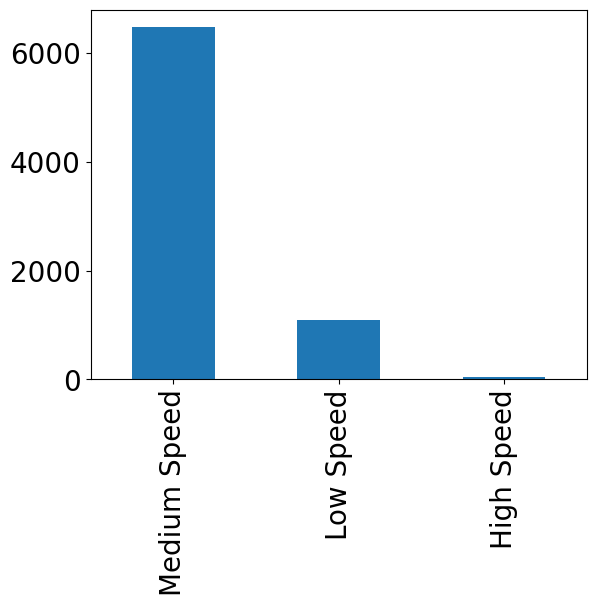

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,Medium Speed
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,Medium Speed
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,Medium Speed
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,Medium Speed


In [45]:
cleanPedDf['speedCategory'].value_counts()
cleanPedDf['speedCategory'].value_counts().plot(kind='bar')
plt.show()
cleanPedDf

In [46]:
# min and max of acceleration
print(cleanPedDf['acceleration'].min())
print(cleanPedDf['acceleration'].max())

0.0005590169945053466
0.3495376410345918


In [47]:
# min and max of sceneYAceleration
print(cleanPedDf['sceneYAcceleration'].min())
print(cleanPedDf['sceneYAcceleration'].max())

-0.3269453639165087
0.2355728036146587


In [48]:
# min and max of positive sceneYAceleration
print(cleanPedDf[cleanPedDf['sceneYAcceleration'] > 0]['sceneYAcceleration'].min())
print(cleanPedDf[cleanPedDf['sceneYAcceleration'] > 0]['sceneYAcceleration'].max())

1.9798552575167605e-05
0.2355728036146587


In [49]:
# categorize sceneYAcceleration into 6 bins
# 3 positive bins, 3 negative bins
# -10 to -.2, -.2 to -.1, -.1 to 0, 0 to .1, .1 to .2, .2 to 10
cleanPedDf['sceneYAccelerationCategory'] = pd.cut(cleanPedDf['sceneYAcceleration'], 
                                                  bins=[-10, -.2, -.1, 0, .1, .2, 10], 
                                                  labels=['High Retardation', 'Medium Retardation', 'Low Retardation', 'Low Acceleration', 'Medium Acceleration', 'High Acceleration'])


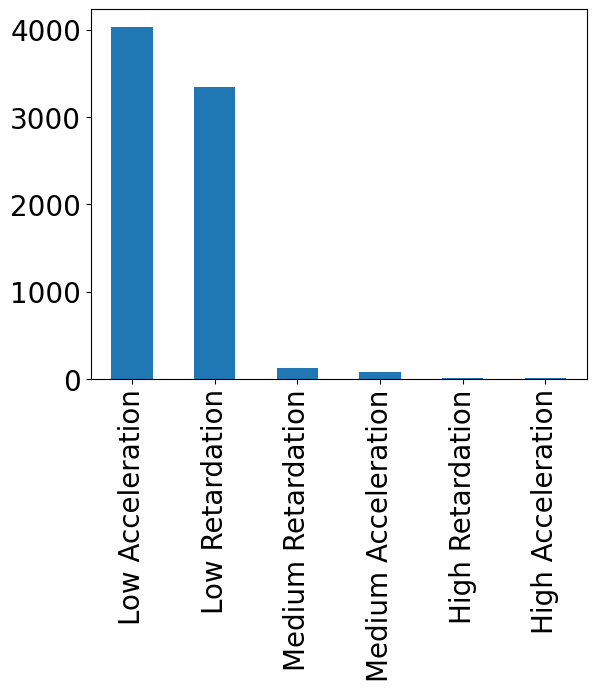

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,sceneYAccelerationCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed,Low Retardation
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed,Low Acceleration
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed,Low Retardation
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed,Low Retardation
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed,Low Acceleration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,Medium Speed,Low Acceleration
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,Medium Speed,Low Retardation
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,Medium Speed,Low Retardation
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,Medium Speed,Low Retardation


In [50]:
cleanPedDf['sceneYAccelerationCategory'].value_counts()
cleanPedDf['sceneYAccelerationCategory'].value_counts().plot(kind='bar')
plt.show()
cleanPedDf

In [51]:
# plot a heatmap of sceneYAccelerationCategory vs speedCategory
# create a pivot table


7600


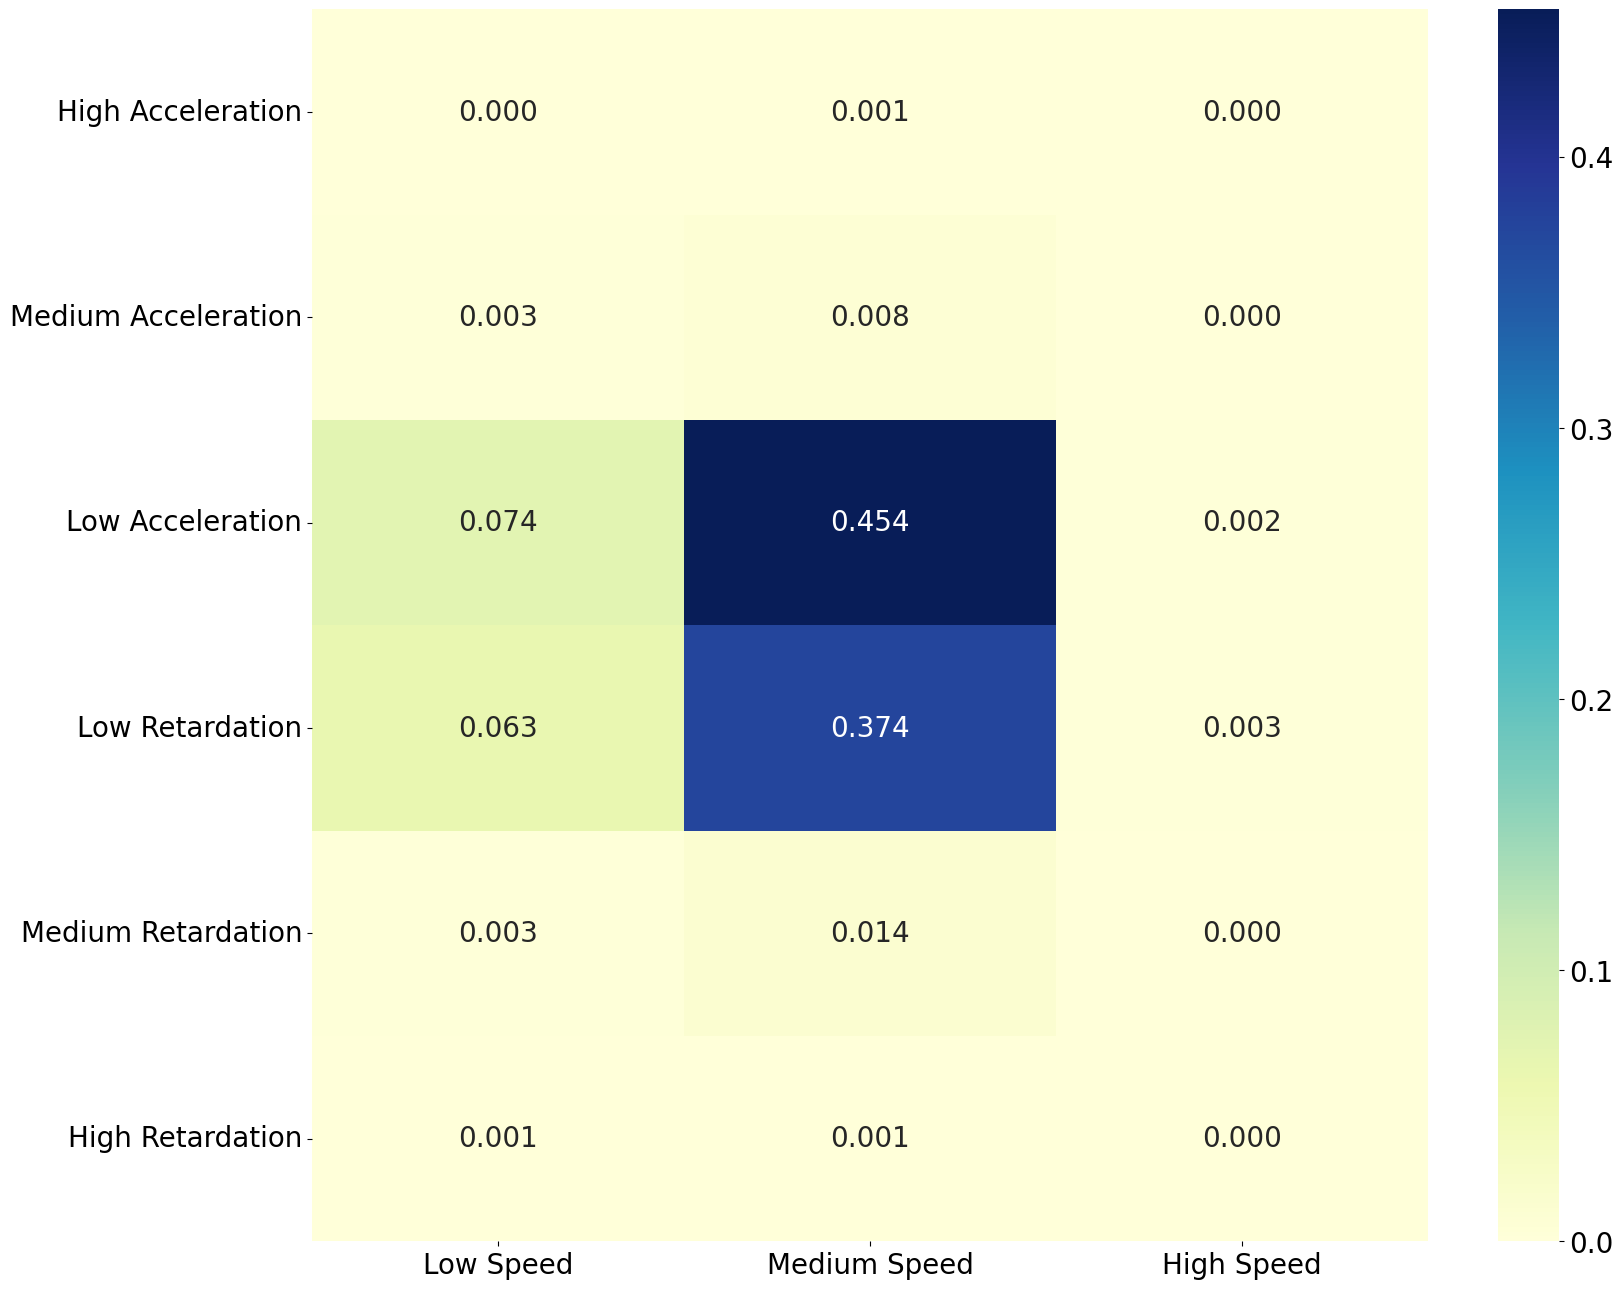

4120


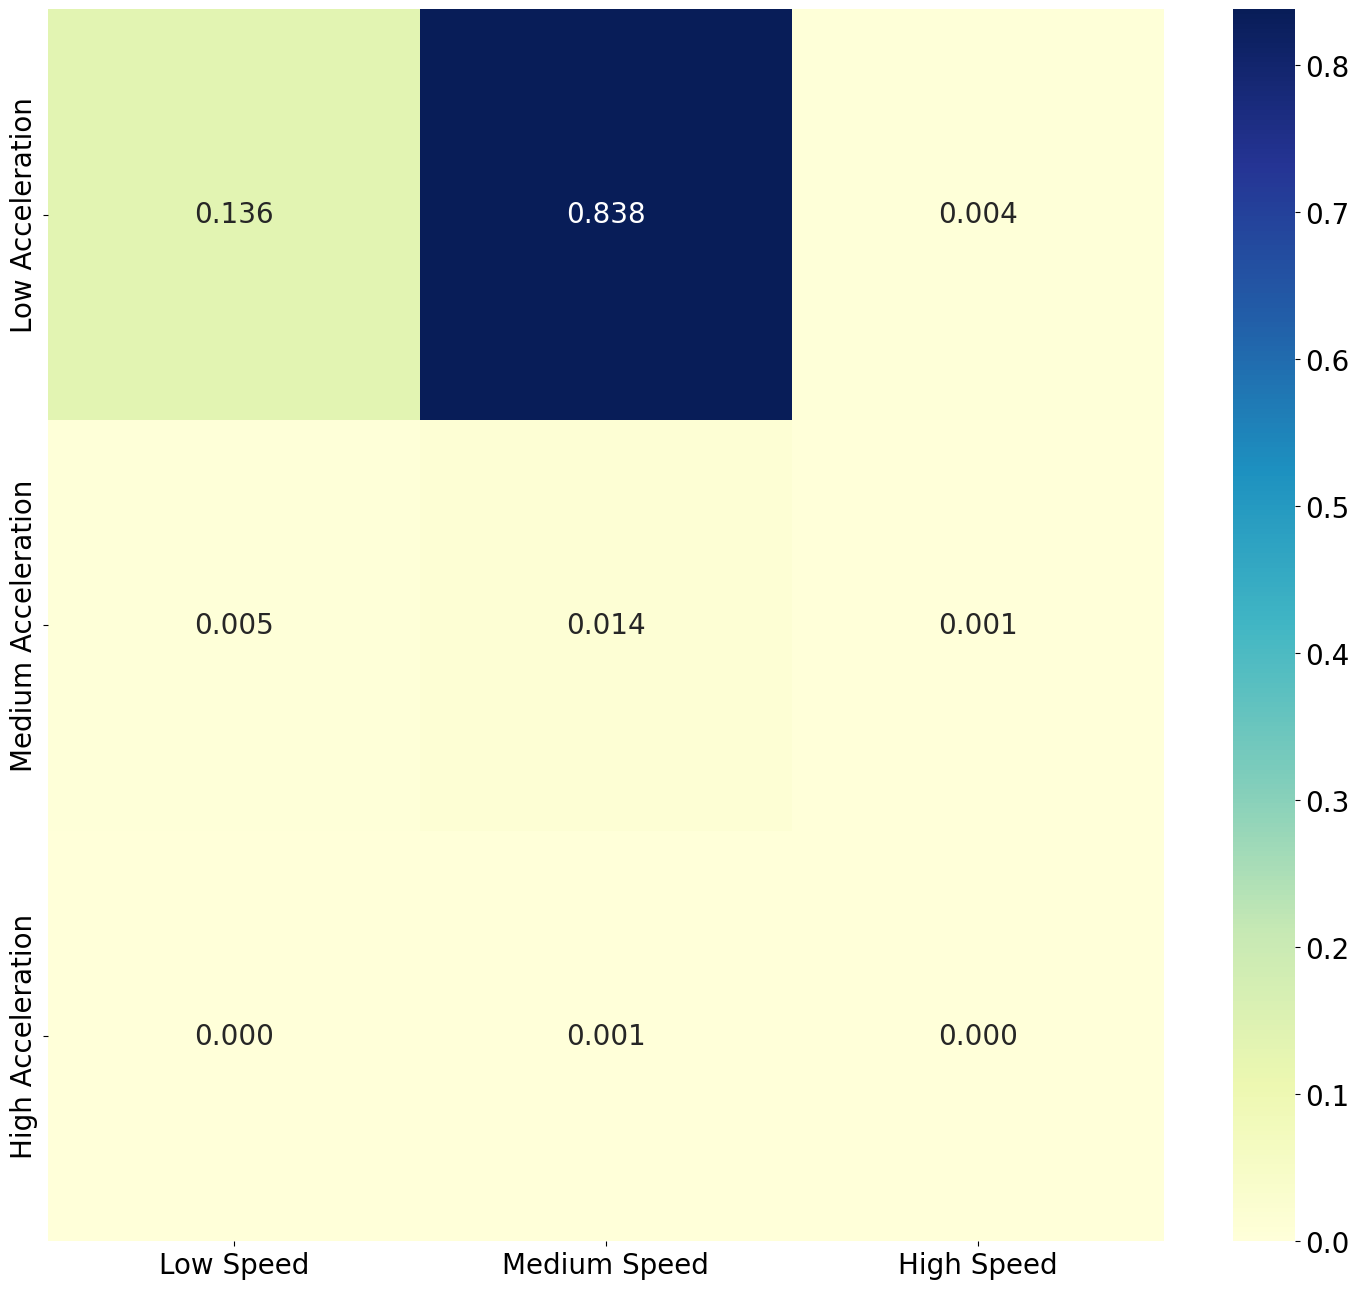

In [62]:
# plot a heatmap
pivot = pd.pivot_table(cleanPedDf, values='uniqueTrackId', index=['sceneYAccelerationCategory'], columns=['speedCategory'], aggfunc='count')
pivot

total = pivot.sum().sum()
print(total)

# plt.figure(figsize=(18, 16))
# sns.heatmap(pivot, annot=True, fmt="d")


plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
plt.figure(figsize=(18, 16))

# reverse the order of rows
pivot = pivot.iloc[::-1]
sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# remove the x and y labels
plt.xlabel('')
plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

plt.show()


pivot = pivot.iloc[:3]
pivot

total = pivot.sum().sum()
print(total)

plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
plt.figure(figsize=(18, 16))

# reverse the order of rows
pivot = pivot.iloc[::-1]
sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# remove the x and y labels
plt.xlabel('')
plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

plt.show()

4120


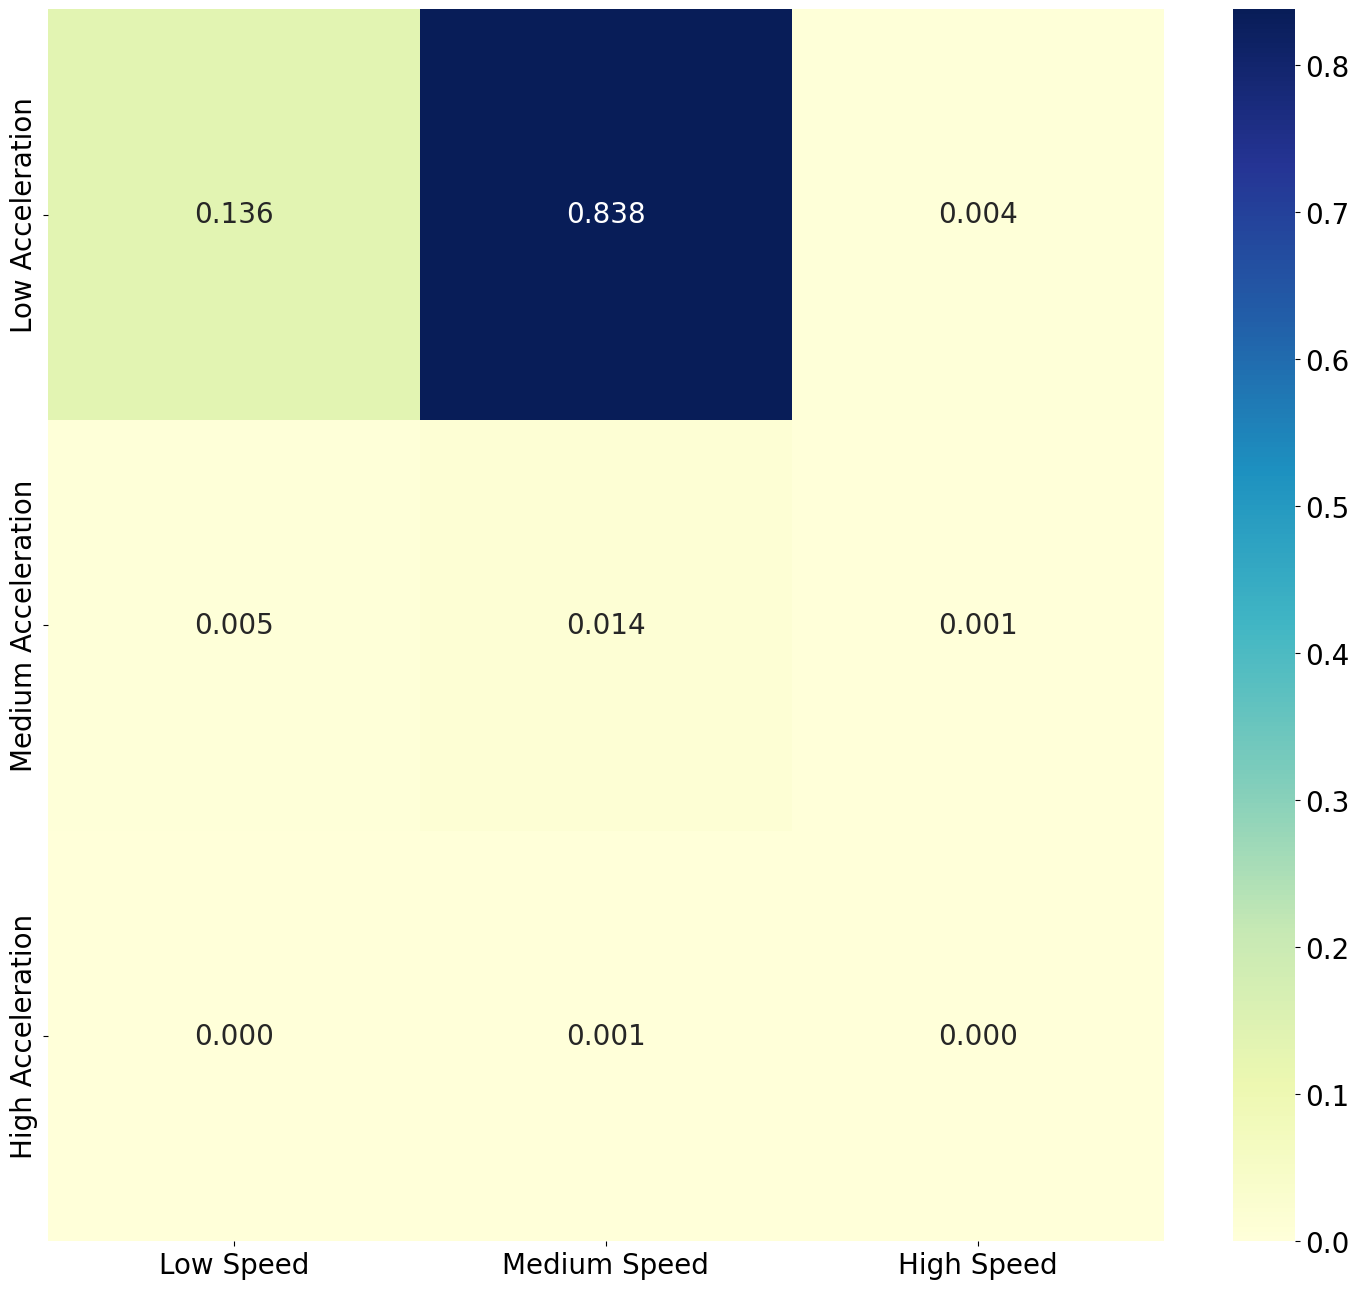

In [61]:
# take the first 3 rows of the pivot table and plot the same heatmap


In [53]:
# cleanPedDf_copy = cleanPedDf.copy()
# # cleanPedDf_copy.head(10)

# NO_OF_CATEGORY = 3

# MIN_SPEED = cleanPedDf_copy["speed"].min()
# MAX_SPEED = cleanPedDf_copy["speed"].max()

# def assign_category(value, min_value, max_value, no_of_category = NO_OF_CATEGORY):
#     bucket_range = math.ceil(max_value - min_value) / no_of_category
    
#     for i in range(no_of_category):
#         if ((i-1)*bucket_range < value) and ((i*bucket_range) >= value):
#                 return i
    
    
# # cleanPedDf_copy["Bucket"] = cleanPedDf_copy["speed"].apply(assign_category(MIN_SPEED, MAX_SPEED))
# cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], min_speed, max_value, NO_OF_CATEGORY)

# cleanPedDf_copy.head(10)

In [54]:
cleanPedDf_copy = cleanPedDf.copy()
cleanPedDf_copy.head(10)
print(len(cleanPedDf_copy), len(cleanPedDf))

NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

# Example usage:
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

print("Min:", min_value, "Max:", max_value)

value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY
print(f"Range in one bucket: {category_range}")

# # Assuming cleanPedDf_copy is your DataFrame
# cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], NO_OF_CATEGORY)
# print("Buckets:", cleanPedDf_copy["Bucket"].min(), cleanPedDf_copy["Bucket"].max())

cleanPedDf_copy.head(10)


7600 7600
Min: 0.18725550726214213 Max: 1.1156748327805872
Range in one bucket: 0.30947310850614834


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,sceneYAccelerationCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed,Low Retardation
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed,Low Acceleration
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed,Low Retardation
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed,Low Retardation
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed,Low Acceleration
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,Low Speed,Low Acceleration
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,Low Speed,Low Acceleration
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,Low Speed,Low Retardation
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,Low Speed,Low Retardation
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,Low Speed,Low Retardation


In [55]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: 0.18725550726214213
Maximum: 1.1156748327805872


In [56]:
# Boolean indexing to filter rows
selected_rows = cleanPedDf_copy[cleanPedDf_copy["speed"] < category_range]

# Print the selected rows
selected_rows

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,sceneYAccelerationCategory
1325,18,20704,18313,210,5.0,1.023349,0.656938,0.005271,0.296247,-0.007759,-0.124922,0.296293,0.393950,1.797915,0.125162,-0.000000,-0.000000,Low Speed,Medium Retardation
5347,20,31156,20475,210,5.0,0.865716,-1.816160,-0.055291,0.292684,-0.005183,0.121831,0.297860,0.236316,4.271013,0.121941,-0.685787,4.313185,Low Speed,Medium Acceleration
5348,20,31158,20475,210,5.0,0.876601,-1.868859,-0.054425,0.263495,-0.004331,0.145943,0.269057,0.247201,4.323712,0.146007,-0.696672,4.365885,Low Speed,Medium Acceleration
5349,20,31160,20475,210,5.0,0.887647,-1.916396,-0.055234,0.237686,0.004046,0.129047,0.244019,0.258248,4.371250,0.129111,-0.707718,4.413422,Low Speed,Medium Acceleration
5350,20,31162,20475,210,5.0,0.899068,-1.959400,-0.057104,0.215021,0.009351,0.113326,0.222474,0.269668,4.414254,0.113711,-0.719139,4.456426,Low Speed,Medium Acceleration
5351,20,31164,20475,210,5.0,0.911042,-1.999649,-0.059871,0.201244,0.013832,0.068882,0.209961,0.281642,4.454503,0.070257,-0.731113,4.496675,Low Speed,Low Acceleration
5352,20,31166,20475,210,5.0,0.923519,-2.036241,-0.062381,0.182963,0.012552,0.091408,0.193305,0.294119,4.491095,0.092266,-0.743590,4.533267,Low Speed,Low Acceleration
5353,20,31168,20475,210,5.0,0.937073,-2.071153,-0.067773,0.174561,0.026962,0.042010,0.187256,0.307673,4.526007,0.049918,-0.757144,4.568179,Low Speed,Low Acceleration
5354,20,31170,20475,210,5.0,0.951749,-2.106942,-0.073376,0.178940,0.028013,-0.021898,0.193400,0.322349,4.561795,0.035556,-0.771819,4.603967,Low Speed,Low Retardation
5355,20,31172,20475,210,5.0,0.967229,-2.143691,-0.077403,0.183747,0.020136,-0.024035,0.199385,0.337829,4.598545,0.031355,-0.787300,4.640717,Low Speed,Low Retardation


In [57]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: -0.3269453639165087
Maximum: 0.2355728036146587


In [58]:
# def assign_acc_category(acc):
#     if acc < 0.1:
#         # print("A")
#         return 1
#     elif (acc >= 0.1) & (acc < 2*0.1):
#         return 2
#     else:
#         return 3
    
# cleanPedDf_copy["accBucket"] = cleanPedDf_copy["acceleration"].apply(assign_acc_category)
# cleanPedDf_copy.head(10)

NO_OF_CATEGORY = 3

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY

def assign_category_acc(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    # value_range = max_value - min_value
    pos_category_range = max_value / num_categories
    print(f"Pos Cat Range = {pos_category_range}")
    neg_category_range = -(min_value) / num_categories
    print(f"Neg Cat Range = {neg_category_range}")

    
    def categorize(acc):
        if acc > 0:
            category = int(acc / pos_category_range)
            return min(category, num_categories - 1)
        else:
            category = int(acc / neg_category_range)
            return max(category - 1, -num_categories)
    
    categories = value_column.apply(categorize)
    return categories

# Assuming cleanPedDf_copy is your DataFrame
cleanPedDf_copy["accBucket"] = assign_category_acc(cleanPedDf_copy["sceneYAcceleration"], NO_OF_CATEGORY)

print("accBucket:", cleanPedDf_copy["accBucket"].min(), cleanPedDf_copy["accBucket"].max())

cleanPedDf_copy.head(10)

Pos Cat Range = 0.07852426787155291
Neg Cat Range = 0.10898178797216956
accBucket: -3 2


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,sceneYAccelerationCategory,accBucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed,Low Retardation,-1
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed,Low Acceleration,0
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed,Low Retardation,-1
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed,Low Retardation,-1
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed,Low Acceleration,0
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,Low Speed,Low Acceleration,0
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,Low Speed,Low Acceleration,0
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,Low Speed,Low Retardation,-1
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,Low Speed,Low Retardation,-1
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,Low Speed,Low Retardation,-1


In [59]:

# firstDf = cleanPedDf[cleanPedDf["speed"] < 1].copy()
# secondDf = cleanPedDf[(cleanPedDf["speed"] >= 1) & (cleanPedDf["speed"] < 2)].copy()
# thirdDf = cleanPedDf[(cleanPedDf["speed"] >= 2)].copy()


In [60]:
# numeric_col = ['speed','sceneYAcceleration']

# startingDf_copy = firstDf
 
# # Correlation Matrix formation
# corr_matrix = startingDf_copy.loc[:,numeric_col].corr()
# # correlation_matrix = startingDf.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.scatter(cleanPedDf_copy["Bucket"], cleanPedDf_copy["accBucket"], marker = ".")

plt.xlim(0.0,3.5) 
plt.xlabel('Speed Category')
plt.ylabel('Acceleration Category')
plt.show()


KeyError: 'Bucket'

<AxesSubplot: >

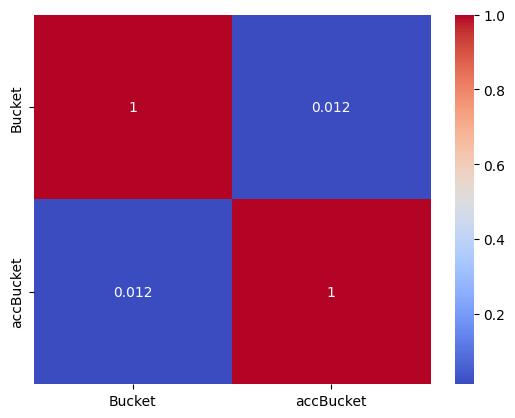

In [ ]:
numeric_col_dis = ['Bucket','accBucket']
startingDf_copy2 = cleanPedDf_copy
# Correlation Matrix formation
corr_matrix_dis = startingDf_copy2.loc[:,numeric_col_dis].corr()
# correlation_matrix = startingDf.corr()
sns.heatmap(corr_matrix_dis, annot=True, cmap='coolwarm')

In [ ]:

# plt.rc('font', size=20)
# plt.rc('axes', labelsize=20) #fontsize of the x and y labels
# plt.scatter(midEditedDf["speed"], midEditedDf["acceleration"], marker = ".")
# for pedId in allPedIds:
#     uniqueTrackId_collection[pedId] = midEditedDf[midEditedDf["uniqueTrackId"] == pedId].copy()
#     plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
# plt.xlabel('Crossed Road Width (m)')
# plt.ylabel('Acceleration ($\mathregular{m/s^{2}}$)')
# plt.grid()
# # plt.savefig("MidAccelerationVsCrossedRoadWidth.png",bbox_inches="tight")
# plt.show()


NameError: name 'midEditedDf' is not defined

7600

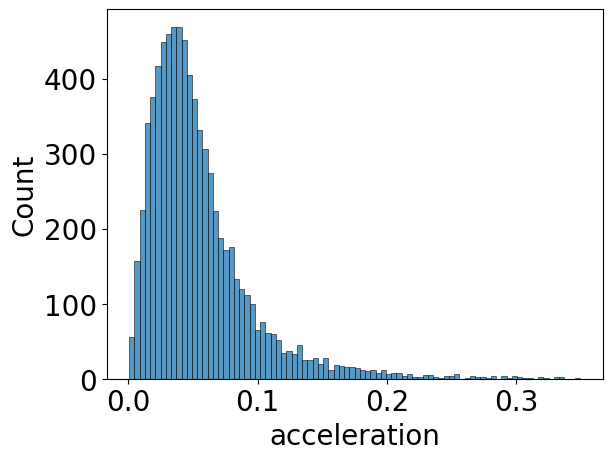

In [ ]:
sns.histplot(cleanPedDf_copy["acceleration"])
len(cleanPedDf_copy)

[[6.000e+00 7.000e+00 0.000e+00]
 [1.600e+01 8.600e+01 5.000e+00]
 [4.470e+02 2.865e+03 4.800e+01]
 [5.110e+02 3.370e+03 6.600e+01]
 [3.800e+01 1.100e+02 1.100e+01]
 [1.000e+00 9.000e+00 4.000e+00]]


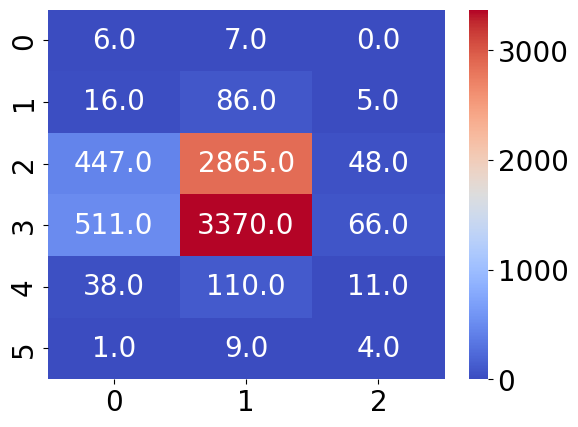

In [ ]:
# Generate some example data
plt.rc('font', size=20)
plt.rc('axes', labelsize=10) #fontsize of the x and y labels

NO_OF_BUCKETS = 3

data = np.zeros((2*NO_OF_BUCKETS, NO_OF_BUCKETS))

for index, row in cleanPedDf_copy.iterrows():
    data[cleanPedDf_copy.loc[index, "accBucket"]+NO_OF_BUCKETS][cleanPedDf_copy.loc[index, "Bucket"]] += 1
        
print(data)

# Create a heatmap using Seaborn
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".1f")

# Show the plot
plt.show()

In [ ]:
print(len(cleanPedDf_copy), len(cleanPedDf))

np.sum(data)

7600 7600


7600.0

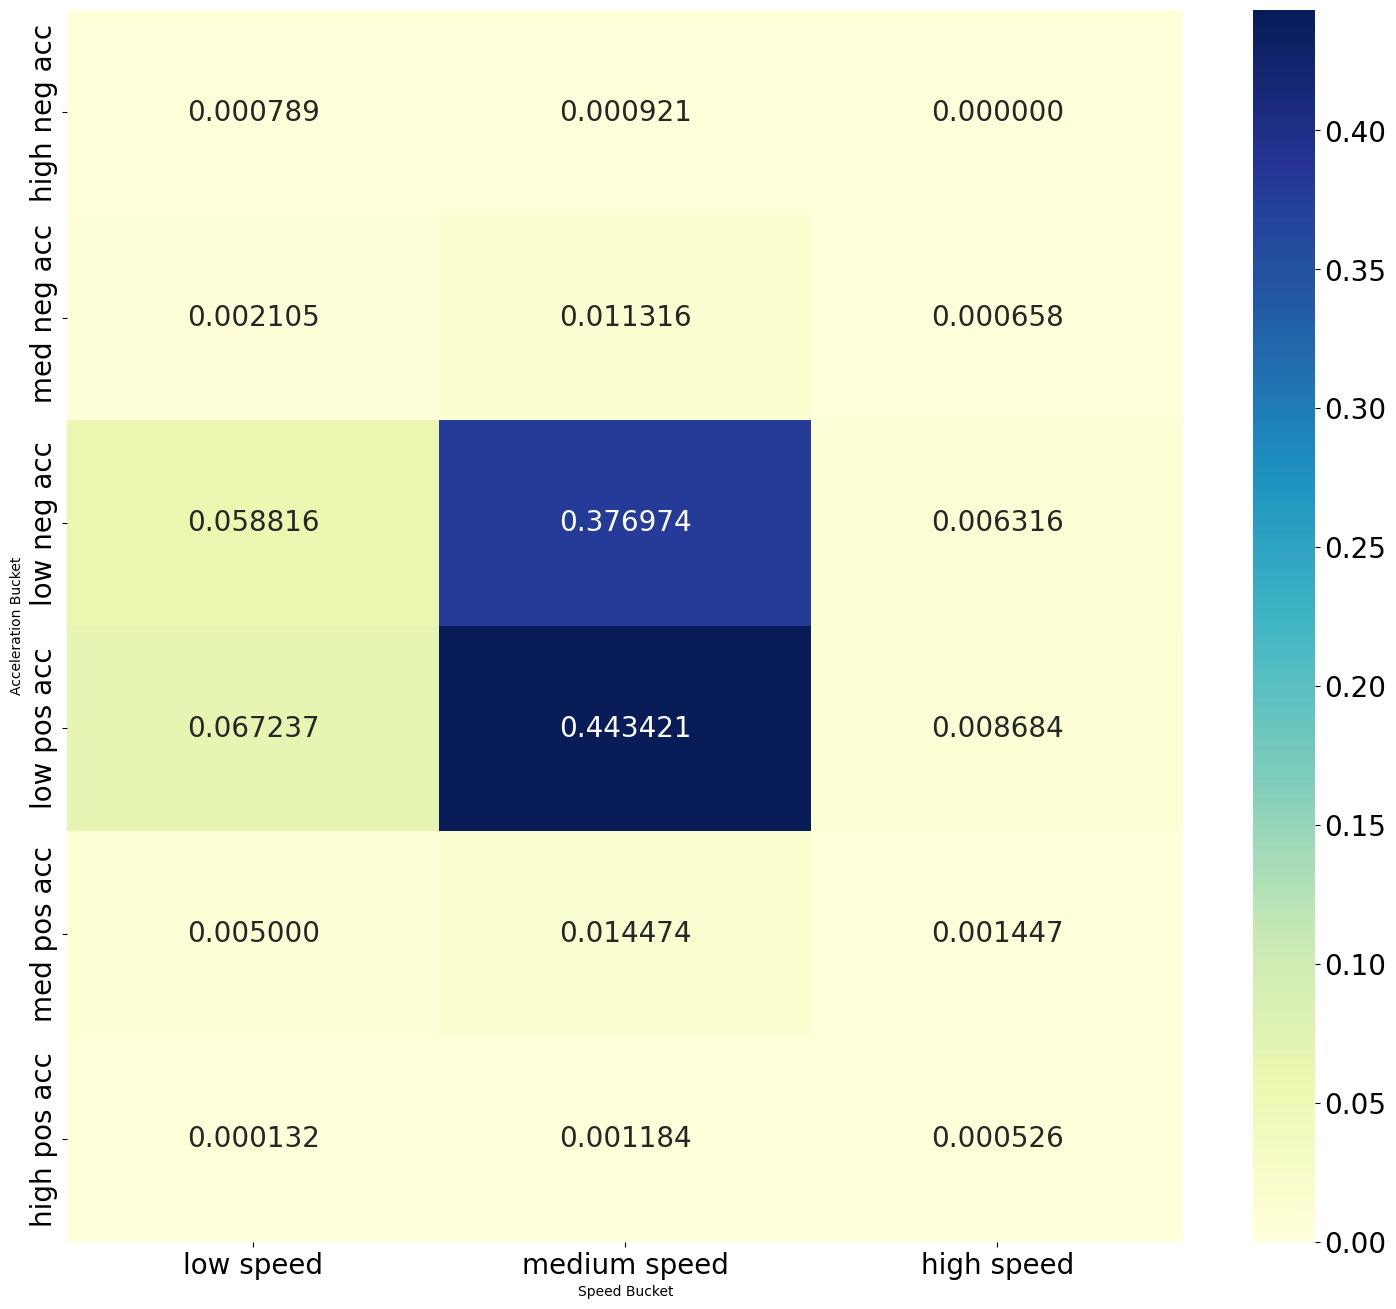

In [ ]:
# Generate example data
# data = np.random.rand(3, 3)

total_length = len(cleanPedDf_copy)
total_length

# Create a heatmap using Seaborn
plt.figure(figsize=(18, 16))
sns.heatmap(data/total_length, annot=True, fmt=".6f", cmap='YlGnBu')

# Customize the axis labels
plt.xlabel("Speed Bucket")
plt.ylabel("Acceleration Bucket")

# Customize the tick labels
x_labels = ["low speed", "medium speed", "high speed"]
y_labels = ["high neg acc", " med neg acc", "low neg acc", "low pos acc", "med pos acc", "high pos acc"]
plt.xticks(np.arange(0.5, NO_OF_BUCKETS + 0.5, 1), x_labels)
plt.yticks(np.arange(0.5, 2*NO_OF_BUCKETS + 0.5, 1), y_labels)

# # Customize the annotation format
# plt.gca().set_xticks(np.arange(3) + 0.5, minor=True)
# plt.gca().set_yticks(np.arange(3) + 0.5, minor=True)
# plt.gca().xaxis.set_tick_params(which="minor", size=0)
# plt.gca().yaxis.set_tick_params(which="minor", size=0)

# Show the plot
plt.show()


In [ ]:
min_value_speed = cleanPedDf_copy["speed"].min()
max_value_speed = cleanPedDf_copy["speed"].max()
value_range = max_value_speed - min_value_speed
category_range = value_range / NO_OF_CATEGORY
print(f"Speed cat Range = {category_range}")

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
# value_range = max_value - min_value
pos_category_range = max_value / NO_OF_CATEGORY
print(f"Pos Cat Range = {pos_category_range}")
neg_category_range = -(min_value) / NO_OF_CATEGORY
print(f"Neg Cat Range = {neg_category_range}")

tempDf = cleanPedDf_copy[(cleanPedDf_copy["speed"] > min_value_speed+category_range) & (cleanPedDf_copy["speed"] < min_value_speed+2*category_range) & (cleanPedDf_copy["sceneYAcceleration"] < pos_category_range) & (cleanPedDf_copy["sceneYAcceleration"] >= 0)]

Speed cat Range = 0.30947310850614834
Pos Cat Range = 0.07852426787155291
Neg Cat Range = 0.10898178797216956


In [ ]:
tempDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0


In [ ]:
tempDf[tempDf["accBucket"] == 0]

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0
